# Clean data

Imagine we want to measure student achievement and growth in seventh grade. We have data that follow students from sixth to seventh grade and describe their demographic characteristics and exit exam scores in core subjects. This notebook walks through common data cleaning tasks on an example dataset that has been engineered to resemble real data with all their issues. The code cleans the data for analysis.

## Load libraries

The tidyverse is a popular collection of R libraries for data science. Most data wrangling tasks use functions from the dplyr and tidyr packages. For details, features, and examples not covered in these examples, please see the documentation [here](https://www.tidyverse.org/packages/).

In [1]:
# Install packages.
req <- c("tidyverse", "fastDummies", "openxlsx")
new <- req[!(req %in% installed.packages()[, "Package"])]
if (length(new)) install.packages(new)

# Load packages.
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)
library(fastDummies)
library(openxlsx)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Thank you for using fastDummies!

To acknowledge our work, please cite the package:

Kaplan, J. & Schlegel, B. (2023). fastDummies: Fast Creation of Dummy (Binary) Columns and Rows from Categorical Variables. Version 1.7.1. URL: https://github.com/jacobkap/fastDummies, https://jacobkap.github.io/fastDummies/.



## Read data

Keep a simple inventory of the files that the program reads and writes at the top of the script. This will orient anyone who reads the code to its requirements and results. Everything the program needs should be contained in the repository.

In [2]:
# Identify inputs and outputs.
PWD <- file.path(getwd(), "..")
STU <- file.path(PWD, "in", "stu.csv")
SCH <- file.path(PWD, "in", "sch.xlsx")
DTA <- file.path(PWD, "out", "data.rda")
OUT <- file.path(PWD, "out", "data.xlsx")

In [3]:
# Load and peek at student data.
# Need to use the function that corresponds to the file type, e.g. csv.
stu <- read.csv(STU)
head(stu)

,sy,stuid,schid,grade,dob,gender,race,iep,math,ela,sci,soc,oss
,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,2018,1,A,6,8/5/2007,2,Black,1,63,60,57,62,0
2,2018,2,A,6,2/26/2007,1,Hispanic,0,86,91,53,87,0
3,2018,3,A,6,3/13/2007,1,Black,1,68,83,54,74,0
4,2018,4,A,6,11/7/2006,2,White,0,77,86,51,84,0
5,2018,5,A,6,4/15/2007,2,White,0,89,95,57,93,0
6,2018,6,A,6,4/18/2007,2,Hispanic,1,61,52,57,57,0


In [4]:
# These are some helpful functions for accessing information about the dataset.
print(paste("Number of rows:", nrow(stu)))
print(paste("Number of columns:", ncol(stu)))

[1] "Number of rows: 210"
[1] "Number of columns: 13"


## Convert text to numeric data

The data describe race using text or "string" data, but for math reasons we need to represent the same information numerically. This section shows two ways we can do this: either as a categorical variable or as a set of mutually exclusive indicator variables. It also addresses dates.

In [5]:
# Race is string data.
table(stu$race)

# Break if we get unexpected values.
# This forces a revisit of the code if the data change.
race_vals <- c("Asian", "Black", "Hispanic", "White")
stopifnot(all(stu$race %in% race_vals))


   Asian    Black Hispanic    White 
      10       72       47       81 

**Technical note.** The code makes extensive use of the `stopifnot()` function as a defensive programming technique. It takes an expression that must evaluate to `TRUE`, and otherwise throws an error and stops the program. This helps document and verify assumptions of the data.

In [6]:
# Cast to factor.
# Each value is now a labeled integer.
stu$race <- as.factor(stu$race)
table(stu$race, as.numeric(stu$race))

          
            1  2  3  4
  Asian    10  0  0  0
  Black     0 72  0  0
  Hispanic  0  0 47  0
  White     0  0  0 81

In [7]:
# Cast to indicators.
# Each category now has its own variable.
stu <- dummy_cols(stu, "race") |>
  rename_with(~ tolower(gsub("race_", "", .x)))

# Check correspondence.
# We can use an existing list to let the code adapt to the data.
stu |>
  group_by(race) |>
  summarize(across(tolower(race_vals), sum))

race,asian,black,hispanic,white
<fct>,<int>,<int>,<int>,<int>
Asian,10,0,0,0
Black,0,72,0,0
Hispanic,0,0,47,0
White,0,0,0,81


**Technical note.** The last example uses the pipe operator "|>" to pass (a) the output of the previous function to (b) the input of the next function. This idiom allows chaining of discrete operations into an easily readable sequence of operations.

In [8]:
# Date of birth is also string data.
table(stu$dob)


 1/10/2007  1/12/2007  1/13/2007  1/18/2007  1/24/2007  1/28/2007   1/8/2007 
         2          2          2          4          5          2          2 
10/14/2006 10/16/2006 10/21/2006 10/23/2006 10/28/2006  10/8/2006 11/16/2006 
         3          2          3          2          2          2          2 
 11/2/2006 11/20/2006 11/28/2006  11/3/2006  11/5/2006  11/7/2006 12/10/2006 
         2          4          3          2          2          2          2 
12/14/2006 12/30/2006 12/31/2006  12/5/2006  12/6/2006  2/16/2007  2/18/2007 
         2          2          2          2          2          3          2 
 2/19/2007  2/20/2007  2/21/2007  2/22/2007  2/26/2007  2/27/2007  2/28/2007 
         3          2          2          2          2          2          2 
  2/5/2007   2/7/2007   3/1/2007  3/10/2007  3/13/2007   3/2/2007  3/28/2007 
         2          2          2          2          4          2          2 
  3/5/2007   4/1/2007  4/14/2007  4/15/2007  4/16/2007  4/18/20

In [9]:
# Cast to date.
# Need to use the function that corresponds to the MM/DD/YYYY pattern.
stu$dob <- mdy(stu$dob)

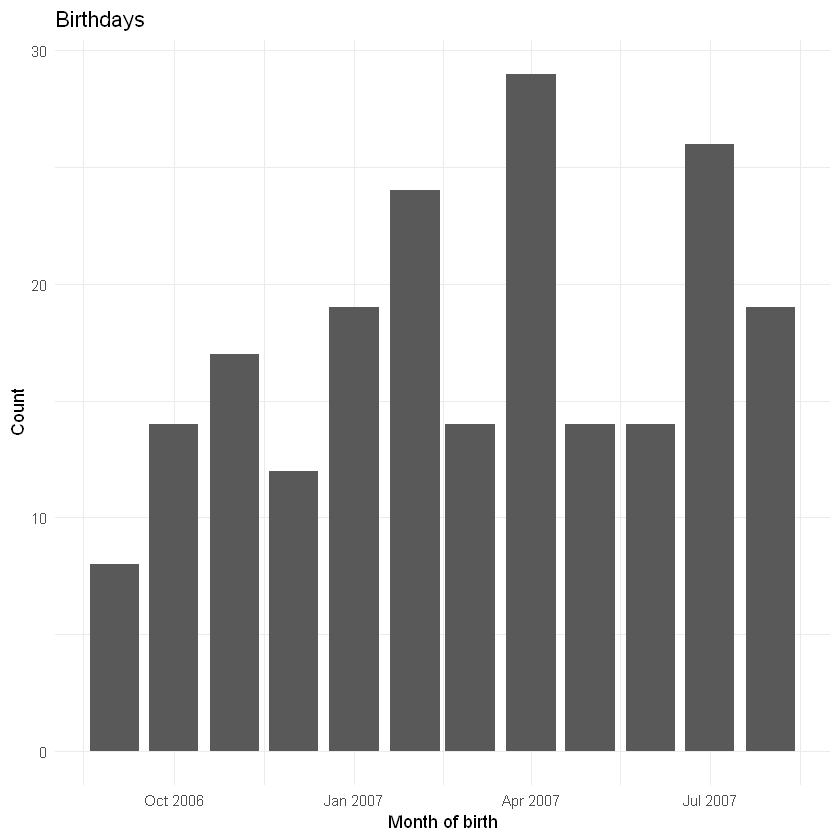

In [10]:
# Plot the distribution of birthdays.
# Bin dates into months.
stu |>
  mutate(mob = floor_date(dob, "month")) |>
  ggplot(aes(x = mob)) +
  geom_bar() +
  labs(
    title = "Birthdays",
    x = "Month of birth",
    y = "Count"
  ) +
  theme_minimal()

## Handle missing data

The data already describe IEP status and subject test scores using numeric values, but they contain impossible values or zero to mark missingness. Without any cleaning, a statistic of these data would be incorrect. This section shows how we can detect and address this encoding of missingness.

In [11]:
# Individualized education plan is an indicator.
summary(stu$iep)
table(stu$iep)

# Break if we get unexpected values.
# What does "-9" mean? This will throw off any summary of IEP status.
iep_vals <- c(-9, 0, 1)
stopifnot(all(stu$iep %in% iep_vals))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-9.00000  0.00000  0.00000  0.02381  1.00000  1.00000 


 -9   0   1 
  8 125  77 

In [12]:
# Set missing values.
# Assume the client gave us this definition.
stu$iep[stu$iep == -9] <- NA

In [13]:
# Check the summary again.
# We can now interpret the mean as the share of students with an IEP.
summary(stu$iep)
stopifnot(all(stu$iep[!is.na(stu$iep)] %in% c(0, 1)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.3812  1.0000  1.0000       8 

In [14]:
# Subject test scores are continuous.
# All subjects have some "-9" values. Social studies has a lot of zeros.
subjs <- c("math", "ela", "sci", "soc")
summary(stu[, subjs])

      math            ela             sci             soc       
 Min.   :-9.00   Min.   :-9.00   Min.   :-9.00   Min.   :-9.00  
 1st Qu.:64.25   1st Qu.:64.00   1st Qu.:51.25   1st Qu.: 0.00  
 Median :77.00   Median :79.00   Median :54.00   Median : 0.00  
 Mean   :73.58   Mean   :74.05   Mean   :55.35   Mean   :36.39  
 3rd Qu.:88.00   3rd Qu.:89.00   3rd Qu.:59.00   3rd Qu.:76.00  
 Max.   :99.00   Max.   :99.00   Max.   :85.00   Max.   :98.00  

In [15]:
# Set missing values.
# Assume the client gave us this definition.
stu <- mutate(stu, across(all_of(subjs), ~ replace(.x, .x == -9, NA)))

**Technical note.** We used base R grammar and tidyverse grammar to make the same replacement to IEP and subject test scores, respectively. Both are correct, however sometimes one is more concise than another. Like with any writing, aim for clear and simple code.

In [16]:
# Note the missingness pattern.
# Students have either all test scores or no test scores.
for (i in seq_along(subjs)) {
  stopifnot(all(is.na(stu[, subjs[1]]) == is.na(stu[, subjs[i]])))
}

# Break if we get unexpected values.
# This only checks that non-missing values are in [0, 100].
for (subj in subjs) {
  stopifnot(min(stu[, subj], na.rm = TRUE) >= 0)
  stopifnot(max(stu[, subj], na.rm = TRUE) <= 100)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 8 rows containing non-finite values (`stat_bin()`)."


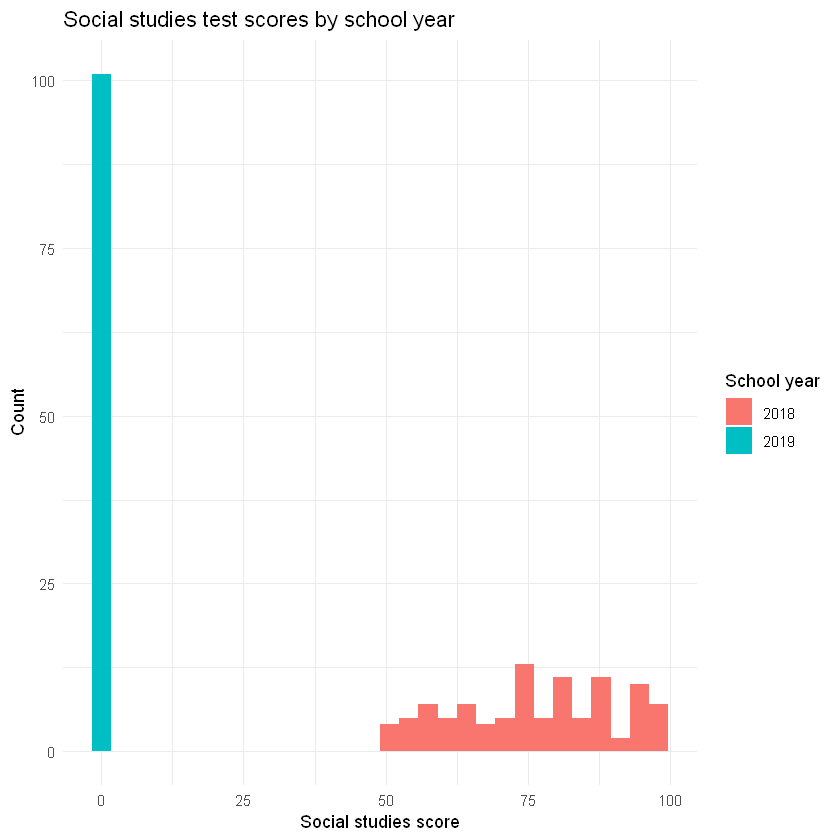

In [17]:
# Plot the distribution of test scores in social studies.
# Zero is perhaps not impossible, but every student received a zero in 2019.
stu |>
  mutate(sy = factor(sy)) |>
  ggplot(aes(x = soc, fill = sy)) +
  geom_histogram(position = "identity") +
  labs(
    title = "Social studies test scores by school year",
    x = "Social studies score",
    y = "Count",
    fill = "School year"
  ) +
  theme_minimal()

In [18]:
# Set missing values.
# Assume we verified that the district awarded no social studies scores in 2019.
stopifnot(all(stu$soc[stu$sy == 2019 & !is.na(stu$soc)] == 0))
stu <- mutate(stu, soc = replace(soc, sy == 2019, NA))

## Handle mixed data types

The data describe gender using a mix of letters and numbers. In this case, a value that looks like a number is actually represented as a string. This section shows how we can reconcile this mismatch and introduces another example of missing data.

In [19]:
# Gender has a mix of numeric and string data.
summary(stu$gender)
table(stu$gender)

# Break if we get unexpected values.
# Need to check what these mean against a codebook!
gender_vals <- c("1", "2", "X")
stopifnot(all(stu$gender %in% gender_vals))

   Length     Class      Mode 
      210 character character 


  1   2   X 
122  86   2 

In [20]:
# Cast to numeric.
# Assume the codebook defines "X" as missing.
# This coerces "X" and all other non-numeric characters to "NA".
stu <- stu |>
  rename(gender_old = gender) |>
  mutate(gender = as.numeric(gender_old))
table(stu$gender_old, stu$gender, useNA = "ifany")

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `gender = as.numeric(gender_old)`.
Caused by warning:
! NAs introduced by coercion"


   
      1   2 <NA>
  1 122   0    0
  2   0  86    0
  X   0   0    2

In [21]:
# Cast to factor.
# Assume the codebook provides this mapping of values to labels.
gender_labs <- c("Male" = 1, "Female" = 2)
stu <- stu |>
  mutate(gender = factor(
    x = gender,
    levels = gender_labs,
    labels = names(gender_labs)
  ))
table(stu$gender, as.numeric(stu$gender), useNA = "ifany")

        
           1   2 <NA>
  Male   122   0    0
  Female   0  86    0
  <NA>     0   0    2

**Technical note.** Notice how creating a factor variable for gender is more involved than creating a factor variable for race. In the previous example, we were not worried about the underlying mapping of labels to integers, e.g. "Hispanic" can be any integer. But in this example, we need to be explicit, e.g. "Male" must be "1".

In [22]:
# Cast to indicators.
# Assume we decided to label anyone categorized as "F" or "X" as "not male".
# Fill "NA" values in the new indicators with zero to complete coverage.
stu <- dummy_cols(stu, "gender") |>
  rename_with(tolower) |>
  rename(c(male = gender_male, female = gender_female)) |>
  mutate(across(c(male, female), ~ if_else(is.na(.x), 0, .x)))

# Check correspondence.
stu |>
  group_by(gender_old, gender) |>
  summarize(across(c(male, female, gender_na), sum))

`summarise()` has grouped output by 'gender_old'. You can override using the
`.groups` argument.


gender_old,gender,male,female,gender_na
<chr>,<fct>,<dbl>,<dbl>,<int>
1,Male,122,0,0
2,Female,0,86,0
X,NA,0,0,2


**Technical note.** There are subtle but important distinctions in types of missingness. Are the data systematically missing, like social studies test scores? Or are they missing at random, like IEP status? Does a missing value for gender mean that the student did not report their gender? Or that they identify as neither male nor female? Can we distinguish these cases? Consider how this applies and whether it could affect the analysis.

## Handle duplicate data

The data follow students over two years, with separate records for each year. Mechanically, multiple records for a student in the same year would up-weight that student in the analysis. But more importantly, duplicates can complicate what we consider to be the truth. This section introduces strategies to deduplicate data and introduces unique identifiers.

In [23]:
# Write a function to check uniqueness of identifiers.
# Use this in a chain of tidyverse functions to check your work.
isid <- function(.data, ...) {
  if(any(duplicated(dplyr::select(.data, ...)))) {
    stop("indexers do not uniquely identify the observations")
  }
  return(.data)
}

In [24]:
# Drop perfect duplicates.
# Check, but it is probably safe to assume no loss of information.
nobs <- nrow(stu)
stu <- unique(stu)
dups <- nobs - nrow(stu)
print(paste("Perfect duplicates:", dups))

[1] "Perfect duplicates: 5"


In [25]:
# Mark remaining duplicates.
# This checks whether the number of rows within a student-year exceeds 1.
stu <- stu |>
  group_by(stuid, sy) |>
  mutate(is_dup = n() > 1) |>
  ungroup()
table(stu$is_dup)


FALSE  TRUE 
  195    10 

In [26]:
# Show duplicates.
# Looks like some have multiple records for suspensions. Which is right?
stu |>
  filter(is_dup) |>
  arrange(stuid, sy) |>
  select(-is_dup)

sy,stuid,schid,grade,dob,gender_old,race,iep,math,ela,⋯,soc,oss,asian,black,hispanic,white,gender,male,female,gender_na
<int>,<int>,<chr>,<int>,<date>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<int>
2018,10,A,6,2007-07-22,1,White,0,98,98,⋯,98,0,0,0,0,1,Male,1,0,0
2018,10,A,6,2007-07-22,1,White,0,98,98,⋯,98,2,0,0,0,1,Male,1,0,0
2018,20,A,6,2007-08-04,2,White,0,73,85,⋯,80,0,0,0,0,1,Female,0,1,0
2018,20,A,6,2007-08-04,2,White,0,73,85,⋯,80,2,0,0,0,1,Female,0,1,0
2018,30,A,6,2006-10-21,2,Black,0,79,80,⋯,79,0,0,1,0,0,Female,0,1,0
2018,30,A,6,2006-10-21,2,Black,0,79,80,⋯,79,2,0,1,0,0,Female,0,1,0
2018,40,A,6,2007-02-16,1,Black,1,61,66,⋯,62,0,0,1,0,0,Male,1,0,0
2018,40,A,6,2007-02-16,1,Black,1,61,66,⋯,62,2,0,1,0,0,Male,1,0,0
2018,50,A,6,2007-02-19,2,White,1,73,58,⋯,58,0,0,0,0,1,Female,0,1,0


In [27]:
# Deduplicate.
# Assume we have no preference between records, so we take the average.
# Student ID and school year now uniquely identify rows in the dataset.
stu <- stu |>
  group_by(stuid, sy) |>
  mutate(oss = if_else(is_dup, mean(oss), oss)) |>
  ungroup() |>
  unique() |>
  isid(stuid, sy)

## Reshape and merge data

The data that describe schools are in a different sort of rectangle than that for students. This section describes changing the shape of the data without changing the data itself. It also shows how to combine two datasets.

In [28]:
# Load and peek at school data.
# Need to use the function that corresponds to the file type, e.g. Excel.
sch <- read.xlsx(SCH, sheet = "sch")
head(sch)

,schid,school_name,frpl18,frpl19,enrl18,enrl19
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,Yuri Andropov Middle School,0.34,0.35,412,399
2,B,Leonid Brezhnev Middle School,0.56,0.52,818,721
3,C,Konstantin Chernenko Elementary School,0.41,0.42,229,241


In [29]:
# Transform to school-year level.
# Note each row describes one school over multiple years. These are "wide" data.
# We can construct a school year variable from the information encoded in the
# column names to make additional rows for each school and school year.
sch <- sch |>
  isid(schid) |>
  pivot_longer(
    # Columns to pivot.
    cols = starts_with(c("frpl", "enrl")),
    # Regular expression to parse data encoded in pivot column names.
    names_pattern = "^([a-z]+)([0-9]+)$",
    # New columns to create; ".value" gets corresponding capture group above.
    names_to = c(".value", "sy"),
    # Cast school year as numeric.
    names_transform = list(sy = as.integer)
  ) |>
  mutate(sy = 2000 + sy) |>
  isid(schid, sy)

**Technical note.** The challenge with `pivot_longer()` is describing how to parse existing column names for variables and values. Here is how it works:
1. The column `frpl18` contains the variables `frpl` and `sy` and the value `18`.
2. The argument `names_pattern` splits the column name `frpl18` into `frpl` and `18`. Notice the two sets of parenthesis to demarcate two capture groups.
3. The argument `names_to` creates columns named `frpl` to store the data and `sy` to store the value `18`. Notice both arguments describe two columns.

In [30]:
# Merge student and school data.
# This adds columns from the second data frame to the first by matching rows on
# shared keys. Note the relationship between the keys of both data frames.
stu_sch_long <- left_join(
  stu,
  sch,
  by = c("schid", "sy"),
  relationship = "many-to-one"
) |>
isid(stuid, sy)

In [31]:
# Check what did not merge.
# Filters the first data frame for rows that do not match in the second. Note
# that all students match, but not all schools do.
check <- anti_join(stu, sch, by = c("schid", "sy"))
stopifnot(nrow(check) == 0)
anti_join(sch, stu, by = c("schid", "sy"))

schid,school_name,sy,frpl,enrl
<chr>,<chr>,<dbl>,<dbl>,<dbl>
C,Konstantin Chernenko Elementary School,2018,0.41,229
C,Konstantin Chernenko Elementary School,2019,0.42,241


**Technical note.** The relationship describes the association between datasets. In this example, "many-to-one" means that we expect to associate many students with one school. And at the same time, we do not expect to associate a student with many schools. A "one-to-one" relationship implies that the datasets have the same unique identifiers. Always check what does not match!

In [32]:
# Make analytic dataset.
# Transform data so that each student in the regression has their own row.
stu_sch_wide <- stu_sch_long |>
  # Ensure data are unique by student-year and student-grade.
  isid(stuid, sy) |>
  isid(stuid, grade) |>
  # Drop unnecessary columns that vary by student.
  select(-c(sy, is_dup)) |>
  # Reshape wide on grade.
  pivot_wider(
    names_from = grade,
    values_from = c(iep, math, ela, sci, soc, oss, frpl, enrl)
  ) |>
  isid(stuid)

## Save clean file

With data cleaning complete, save the analysis file for use in the analysis program. Come back to the cleaning program to implement major revisions that the analysis requires. Aim to keep the workflow simple so that anyone who looks through the repository can follow along.

In [33]:
# Save to load into another R program.
# This saves the long and wide datasets just as they are.
save(stu_sch_long, stu_sch_wide, file = DTA)

# Save to Excel workbook.
# Provide a named list to write multiple datasets to different worksheets.
ws <- list("long" = stu_sch_long, "wide" = stu_sch_wide)
write.xlsx(ws, OUT)